<a href="https://colab.research.google.com/github/georgiepayne/reddit_mental_health_sentimentanalysis/blob/master/reddit_mental_health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets
!pip install nltk  # Package used for prepocessing data
!pip install pyspellchecker # Package used to correct spelling

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 21.8 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import string
import nltk
from nltk.corpus import stopwords  # To help get a list of stopwords to exclude
nltk.download('stopwords') # The word bank we references to delete stopwords
from collections import Counter # To help count the frequent words
from nltk.stem.porter import PorterStemmer  # To help stem words
from spellchecker import SpellChecker  # To help correct spelling
import re  # To help remove urls
import gensim.downloader as gensim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

# Libraries to help perform word embeddings on the the text
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
ds_load = load_dataset("solomonk/reddit_mental_health_posts")
print(type(ds_load['train']))

df = pd.DataFrame(ds_load['train'])

# Replace the body with a title any time it gets deleted or removed

# Strip any whitespace from the `body` column
body_stripped = df['body'].str.strip()

# Check if the `body` contains `[deleted]` or `[removed]`
is_deleted = body_stripped.isin(['[deleted]', '[removed]'])

# Replace the entry in body with the entry in title
df.loc[is_deleted, 'body'] = ""

df.head(10)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/425 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


adhd.csv:   0%|          | 0.00/29.6M [00:00<?, ?B/s]

aspergers.csv:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

depression.csv:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

ocd.csv:   0%|          | 0.00/29.8M [00:00<?, ?B/s]

ptsd.csv:   0%|          | 0.00/20.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/151288 [00:00<?, ? examples/s]

<class 'datasets.arrow_dataset.Dataset'>


,author,body,created_utc,id,num_comments,score,subreddit,title,upvote_ratio,url
0,HotConversation1273,A few months ago I was accepted into this full...,2021-12-22T18:32:56.000Z,rmbjwb,1,1,ADHD,I get extremely anxious if I’m not working 24/7,1.0,https://www.reddit.com/r/ADHD/comments/rmbjwb/...
1,snorefestt,"Hey guys, I was curious if anyone else has the...",2021-12-22T18:24:25.000Z,rmbd1y,3,5,ADHD,"I can't will myself to clean my own house, but...",1.0,https://www.reddit.com/r/ADHD/comments/rmbd1y/...
2,etyf12,\n\ni have 6 exams in the next 2 weeks one of...,2021-12-22T18:22:52.000Z,rmbbvu,1,2,ADHD,i need some help,1.0,https://www.reddit.com/r/ADHD/comments/rmbbvu/...
3,GetHairOrDieTryin,Is there anyone out there that is struggling w...,2021-12-22T18:20:35.000Z,rmba1t,3,2,ADHD,Anyone up for a chat?,1.0,https://www.reddit.com/r/ADHD/comments/rmba1t/...
4,ZeroTransPat,"Whenever I get hungry, I never eat because I d...",2021-12-22T18:18:47.000Z,rmb8lm,2,1,ADHD,Figuring out what to eat sucks,1.0,https://www.reddit.com/r/ADHD/comments/rmb8lm/...
5,[deleted],,2021-12-22T18:18:19.000Z,rmb88p,1,1,ADHD,Watching movies at x1.5 playback speed,1.0,https://www.reddit.com/r/ADHD/comments/rmb88p/...
6,Used_Inspection2618,I’m on 20 mg of Lexapro and 50 mg Vyvanse and ...,2021-12-22T18:15:52.000Z,rmb6f2,4,1,ADHD,Drinking while on meds?,1.0,https://www.reddit.com/r/ADHD/comments/rmb6f2/...
7,TheToastyToad,"I've recently had a big lifestyle change, with...",2021-12-22T18:13:15.000Z,rmb47u,1,2,ADHD,Using Christmas to take a break,1.0,https://www.reddit.com/r/ADHD/comments/rmb47u/...
8,Field-cave1519,"I'm a newly diagnosed 42 yr old female, who st...",2021-12-22T18:11:07.000Z,rmb2i8,1,1,ADHD,Does everyone get the euphoria feeling when th...,1.0,https://www.reddit.com/r/ADHD/comments/rmb2i8/...
9,Away_Entertainment29,TL;DR - rough time titrating on concerta for t...,2021-12-22T18:09:50.000Z,rmb1ib,1,1,ADHD,Xaggatin: zoned out and angry,1.0,https://www.reddit.com/r/ADHD/comments/rmb1ib/...


In [ ]:
# Helper functions that the preprocess function calls

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Helper functions that the preprocess function calls
def remove_stopwords(text):

  # Get the stopwords from from the english language
  # This data is found in the stopwords libarary
  STOPWORDS = set(stopwords.words('english'))

  # Split the string into and array of words
  words = str(text).split()

  filtered = []  # To keep track of the filtered words

  # Loop through the words array
  for word in words:

    # Append any words not in the STOPWORDS array
    filtered.append(word) if word not in STOPWORDS else None

  # Make the final string by adding spaces between all stop words
  cleaned_string = " ".join(filtered)
  return cleaned_string

def remove_frequent_and_rare(data, top_n=10, min_frequency=10):
  counter = Counter()  # make a counter

  # Count words from both 'body' and 'title' columns
  for col in ["body", "title"]:
    # get entrues as strings
    data[col] = data[col].astype(str)

    # update counter for each word
    for text in data[col]:
      for word in text.split():
        counter[word] +=1

  # Get the top N most frequent words
  most_frequent_words = {word for word, _ in counter.most_common(top_n)}

  # Get the rare words (show up less than min_frequency)
  rare_words = {word for word, count in counter.items() if count < min_frequency}

  # Combine frequent and rare words to be filtered out
  words_to_filter = most_frequent_words.union(rare_words)

  # Filter the 'body' and 'title' columns
  for col in ["body", "title"]:
    filtered_column = []
    for text in data[col]:
      words = text.split()
      filtered_words = [word for word in words if word not in words_to_filter]
      filtered_column.append(" ".join(filtered_words))

    # Update the DataFrame column
    data[col] = filtered_column

  return data

def lemmatize(text):
  # lemmatizer to gets words in root form
  lemmatizer = WordNetLemmatizer()

  # for tagged text so lemmatizer knows the type of word
  wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
  pos_tagged_text = nltk.pos_tag(text.split())

  lemmatized_words = []

  # get as noun and lemmatize
  for word, tag in pos_tagged_text:
    tag = wordnet_map.get(tag[0], wordnet.NOUN)
    lemmatized_word = lemmatizer.lemmatize(word, tag)
    lemmatized_words.append(lemmatized_word)
  return ' '.join(lemmatized_words)

def expand_abbreviations(text):

  # Turn a the text file containing abbreviations into a data frame
  path = "abbreviations.txt"
  df = pd.read_csv(path, sep="=", names=["abbreviation", "expanded"], header=None)

  abbreviations_dictionary = {}

  # I work with arrays better so I'm converting it into one
  data_array = df[["abbreviation", "expanded"]].values

  # Fill up the dictionary
  for row in data_array:
    abbreviation = row[0]
    expanded = row[1]
    abbreviations_dictionary[abbreviation] = expanded

  expanded_text = []

  words = text.split()

  # Go through the text
  for word in words:
    # Check if the abbreviation matches anything in the dictionary
    if word in abbreviations_dictionary:
      expanded_text.append( abbreviations_dictionary[word] )
    else:
      expanded_text.append(word)

  cleaned_string = " ".join(expanded_text)
  return cleaned_string


def remove_urls(text):
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  return url_pattern.sub(r'', text)

In [ ]:
# Preprocessing function the cleans the the input data
def preprocess(data):

  # remove urls
  data["body"] = data["body"].apply(lambda text: remove_urls(text) if text is not None else text)
  data["title"] = data["title"].apply(lambda text: remove_urls(text) if text is not None else text)

  # Set everything to lowercase
  data["body"] = data["body"].str.lower()
  data["title"] = data["title"].str.lower()

   # expand abbreviations
  data["body"] = data["body"].apply(lambda text: expand_abbreviations(text) if text is not None else text)
  data["title"] = data["title"].apply(lambda text: expand_abbreviations(text) if text is not None else text)

  # Remove all punctuation
  data["body"] = data["body"].apply(lambda text: remove_punctuation(text) if text is not None else text)
  data["title"] = data["title"].apply(lambda text: remove_punctuation(text) if text is not None else text)

  # remove stop words
  data["body"] = data["body"].apply(lambda text: remove_stopwords(text) if text is not None else text)
  data["title"] = data["title"].apply(lambda text: remove_stopwords(text) if text is not None else text)

  # apply lemmatization
  data["body"] = data["body"].apply(lambda text: lemmatize(text) if text is not None else text)
  data["title"] = data["title"].apply(lambda text: lemmatize(text) if text is not None else text)

  return data

In [ ]:
preprocessed_df = preprocess(df)

# remove frequent words and rare words
preprocessed_df = remove_frequent_and_rare(preprocessed_df, top_n=5, min_frequency=15)

print(preprocessed_df.head())

In [ ]:
preprocessed_df.to_csv('preprocessed_data.csv', index=False)

In [ ]:
preprocessed_df = pd.read_csv('preprocessed_data.csv')
preprocessed_df['body'] = preprocessed_df['body'].fillna('')
preprocessed_df['title'] = preprocessed_df['title'].fillna('')

In [ ]:
X = preprocessed_df[['body', 'title']]   # Input the model uses to make a prediction
y = preprocessed_df['subreddit']         # Metal health issue the model should predict

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
print(y_train.value_counts())
print(y_test.value_counts())

subreddit
OCD           30711
ADHD          26795
ptsd          17328
depression    17297
aspergers     16796
Name: count, dtype: int64
subreddit
OCD           8711
ADHD          7328
depression    4796
ptsd          4755
aspergers     4668
Name: count, dtype: int64


In [ ]:
# sklearn count vectorizer

def vectorize(data):
  vectorizer = CountVectorizer()

  # Combine the body and title text into a single column
  combined_data = data['body'] + " " + data['title']

  # Fit the combined text
  vector = vectorizer.fit_transform(combined_data)

  return vector, vectorizer

In [ ]:
X_train_vector, vectorizer = vectorize(X_train)
X_val_vector = vectorizer.transform(X_val['body'] + " " + X_val['title'])
X_test_vector = vectorizer.transform(X_test['body'] + " " + X_test['title'])

In [ ]:
from imblearn.over_sampling import SMOTE

# Oversample the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_vector, y_train)

# Check the new class distribution
print(pd.Series(y_train_balanced).value_counts())

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


subreddit
ADHD          30711
ptsd          30711
aspergers     30711
depression    30711
OCD           30711
Name: count, dtype: int64


Accuracy: 0.7510740961068147
              precision    recall  f1-score   support

        ADHD       0.77      0.78      0.77      7328
         OCD       0.87      0.79      0.83      8711
   aspergers       0.66      0.68      0.67      4668
  depression       0.64      0.73      0.68      4796
        ptsd       0.75      0.72      0.74      4755

    accuracy                           0.75     30258
   macro avg       0.74      0.74      0.74     30258
weighted avg       0.76      0.75      0.75     30258



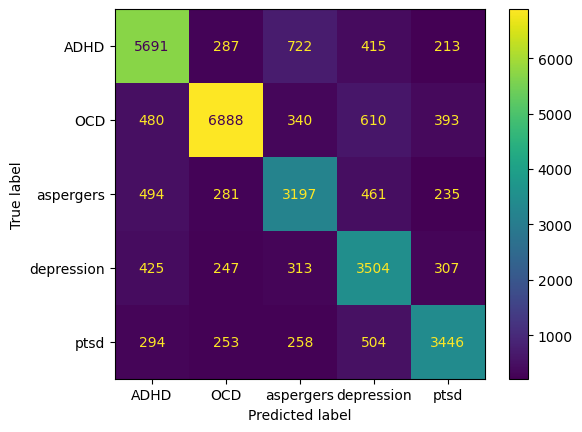

In [ ]:
# Create a Multinomial Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_balanced, y_train_balanced)

y_pred = nb_model.predict(X_test_vector)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print(classification_report(y_test, y_pred))

class_labels = sorted(y_test.unique())

cf = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=class_labels)
disp.plot()

In [ ]:
def predict_disorder(body, title):
  # preprocess input
  preprocessed_input = preprocess(pd.DataFrame({'body': [body], 'title': [title]}))
  preprocessed_input['body'] = preprocessed_input['body'].fillna('')
  preprocessed_input['title'] = preprocessed_input['title'].fillna('')

  # vector transform
  vector = vectorizer.transform(preprocessed_input['body'] + " " + preprocessed_input['title'])

  # predict with logistic regression
  y_pred = nb_model.predict(vector)

  # return the prediction
  return y_pred[0]

In [ ]:
# examples of different posts from reddit
print(f'predicted disorder:')
print(predict_disorder("I literally have no friends. I try to play it off like I don't care but I really do.I cry at night when no one can hear me because I don't want to bother them. I feel like I'm suffocating, I want to tear off my skin so I can feel something else. I've had multiple attempts in the past year and I can't even do that right. I can't do anything correctly. I really do want to die.",
                       "Lonely"))

predicted disorder:
depression


In [ ]:
print(f'predicted disorder:')
print(predict_disorder("I beileve I have ADHD, which is loads and loads of worthless thought bubbles, but sometimes these thoughts can act as if they're day dreams. I have maladaptive daydreaming too. Some are intrusive thoughts I don't like, don't want to get involved in. Don't wanna answer. Very bad thoughts, gives me anxiety and train fog. What is OCD and what is adhd.",
                       "What's the difference between ADHD and OCD? I'm really confused, I'm not sure what I have."))

predicted disorder:
OCD


In [ ]:
print(f'predicted disorder:')
print(predict_disorder("I have had several issues with my social life. I was bullied for a long while by a group of men in university, that I thought I was cool with. I isolated myself, and never really was at school. No canteen, no lectures, nothing. I never adressed the bullying, even with the difficult stomach feeling I would get. I have had some struggles with socialization throughout my life. But I have had times where I've had hope. I don't want to give up. I retreat too much. I think everyone hates me, when often they don't. I limit my own relationships. What often scares me is my difficulty with social dynamics. And social status. How to work through disrespect and difficult situations. How to trust my intuition. Or train my intuition to not only be a social anxious wreck, but actually be a bit helpful.",
                       "Social difficulties: Is there hope?"))

predicted disorder:
aspergers


In [ ]:
print(f'predicted disorder:')
print(predict_disorder(body = "ive been feeling really sad",
                       title = "very down these days"))

predicted disorder:
depression
